# Семантическая и инстанс сегментация листьев растений


In [2]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.models import resnet50

from metrics import DiceLoss, CombinationLoss
from unet import Unet
from training import train, validate

import sys
import cv2
from google.colab.patches import cv2_imshow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
!gdown 1T6cNkanLzh6xMZ2plIEWTZ0Uy-tsUP0f
!sudo apt-get install fastjar
!jar xvf CVPPPSegmData.zip

Downloading...
From (original): https://drive.google.com/uc?id=1T6cNkanLzh6xMZ2plIEWTZ0Uy-tsUP0f
From (redirected): https://drive.google.com/uc?id=1T6cNkanLzh6xMZ2plIEWTZ0Uy-tsUP0f&confirm=t&uuid=37734815-efc8-41b2-88f8-455bff8681f9
To: /content/CVPPPSegmData.zip
100% 440M/440M [00:21<00:00, 20.8MB/s]
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fastjar
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 67.1 kB of archives.
After this operation, 191 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fastjar amd64 2:0.98-7 [67.1 kB]
Fetched 67.1 kB in 1s (50.0 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Rea

Посмотрим, как выглядят изображения:

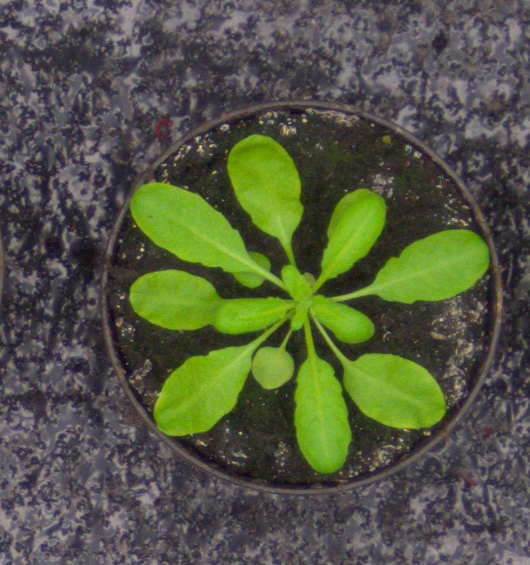

In [4]:
img = cv2.imread("/content/CVPPPSegmData/data/A2/plant039_rgb.png", cv2.IMREAD_ANYCOLOR)

cv2_imshow(img)

Теперь подготовим датасет и разделим на `train`, `val` и `test`. В качестве `val` я возьму данные из сплита `dev`.

In [5]:
data = pd.read_csv("/content/CVPPPSegmData/split.csv")

In [6]:
def extract_data(segment):
  dt = data[data['split'] == segment]
  images = []
  for image in dt["img_path"]:
    img = cv2.imread("/".join(["/content/CVPPPSegmData", image]), cv2.IMREAD_ANYCOLOR)
    images.append(img)

  segments = []
  for image in dt["sem_path"]:
    img = cv2.imread("/".join(["/content/CVPPPSegmData", image]), cv2.IMREAD_ANYCOLOR)
    segments.append(img)
  return images, segments

In [7]:
train_images, train_segments = extract_data('train')
val_images, val_segments = extract_data('dev')
test_images, test_segments = extract_data('test')

In [8]:
print('train:',len(train_images), "val:",len(val_images), 'test:',len(test_images))

train: 712 val: 35 test: 63


Сожмем изображения:

In [9]:
def squeeze_images(images, segments, size=(256, 256)):
  X = [cv2.resize(x, size) for x in images]
  Y = [cv2.resize(y, size) > 0.5 for y in segments]
  return X, Y

In [10]:
X_train, Y_train = squeeze_images(train_images, train_segments)
X_val, Y_val = squeeze_images(val_images, val_segments)
X_test, Y_test = squeeze_images(test_images, test_segments)

В таргетах изображения с разным количеством каналов, я делают следующую обработку, чтобы тензоры были одинакового размера.

In [11]:
def prepare_data(Y):
  newY = []
  for k in range(len(Y)):
    if len(Y[k].shape) == 3:
      image = Y[k]
      new_image = []
      for i in range(len(image)):
        new_row = []
        for j in range(len(image[0])):
          new_row.append(max(image[i][j]))
        new_image.append(new_row)
      newY.append(new_image)
    else:
      newY.append(Y[k])
  newY = torch.tensor(np.array(newY), dtype=float)
  newY = newY[:,:, None].permute(0, 2, 1, 3)
  return newY

In [12]:
Y_train = prepare_data(Y_train)
Y_val = prepare_data(Y_val)
Y_test = prepare_data(Y_test)

In [13]:
X_train = torch.tensor(np.array(X_train), dtype=float).permute(0, 3, 1, 2)
X_val = torch.tensor(np.array(X_val), dtype=float).permute(0, 3, 1, 2)
X_test = torch.tensor(np.array(X_test), dtype=float).permute(0, 3, 1, 2)

<ipython-input-13-9271221060ef>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  X_train = torch.tensor(X_train, dtype=float).permute(0, 3, 1, 2)


In [39]:
batch_size = 10
data_train = DataLoader(list(zip(X_train, Y_train)),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(X_val, Y_val)),
                     batch_size=batch_size)
data_test = DataLoader(list(zip(X_test, Y_test)),
                     batch_size=batch_size)

In [15]:
import torch

model = Unet(classes=1)

criterion = CombinationLoss()

optimizer = torch.optim.Adam(model.parameters())

In [16]:
train_losses = []
val_losses = []

# Defining a Training Function
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# Running our training loop
num_epochs = 20 # set number of epochs
# Place the model on the right device
model = model.to(device)
for epoch in range(num_epochs):
    train_loss = train(model, data_train, criterion, optimizer, epoch, num_epochs, device)
    train_losses.append(train_loss)
    val_loss = validate(model, data_val, criterion, device)
    val_losses.append(val_loss)

Epoch [001/020] | Train Loss: 0.4627
Validation Loss: 0.2840 
Epoch [002/020] | Train Loss: 0.1411
Validation Loss: 0.0619 
Epoch [003/020] | Train Loss: 0.0539
Validation Loss: 0.0464 
Epoch [004/020] | Train Loss: 0.0473
Validation Loss: 0.0307 
Epoch [005/020] | Train Loss: 0.0326
Validation Loss: 0.0268 
Epoch [006/020] | Train Loss: 0.0299
Validation Loss: 0.0223 
Epoch [007/020] | Train Loss: 0.0278
Validation Loss: 0.0425 
Epoch [008/020] | Train Loss: 0.0727
Validation Loss: 0.0336 
Epoch [009/020] | Train Loss: 0.0320
Validation Loss: 0.0335 
Epoch [010/020] | Train Loss: 0.0273
Validation Loss: 0.0220 
Epoch [011/020] | Train Loss: 0.0245
Validation Loss: 0.0212 
Epoch [012/020] | Train Loss: 0.0243
Validation Loss: 0.0205 
Epoch [013/020] | Train Loss: 0.0234
Validation Loss: 0.0213 
Epoch [014/020] | Train Loss: 0.0219
Validation Loss: 0.0193 
Epoch [015/020] | Train Loss: 0.0215
Validation Loss: 0.0186 
Epoch [016/020] | Train Loss: 0.0214
Validation Loss: 0.0187 
Epoch [0

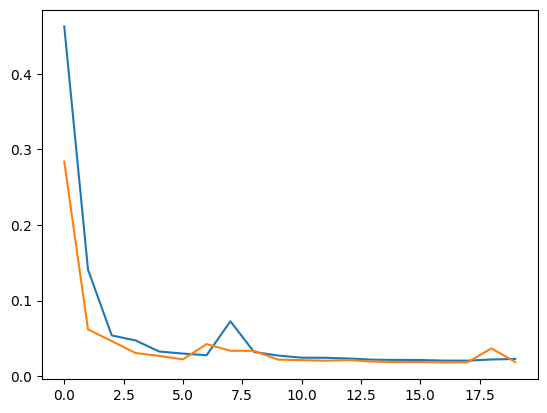

In [17]:
plt.plot(range(len(train_losses)), train_losses, val_losses);

In [45]:
dice_loss = 0
mse_loss = 0
outputs = []

for inputs, targets in data_test:
  inputs = inputs.to(device, dtype=torch.float)
  targets = targets.to(device, dtype=torch.float)
  output = model(inputs)
  mse_loss += nn.MSELoss()(output, targets).item()
  dice_loss += DiceLoss()(output, targets).item()
  outputs.extend(output)

avg_dice_loss = dice_loss / len(data_test)
avg_mse_loss = mse_loss / len(data_test)

In [44]:
assert avg_dice_loss <= 0.05
assert avg_mse_loss <= 156
print("MSE:", avg_mse_loss)
print("DICE:", avg_dice_loss)

MSE: 155.86357225690568
DICE: 0.02402458872113909


Сохраним картинки, которые получились в результате:

In [43]:
os.mkdir("segmentation_images")

for i, output in enumerate(outputs):
  save_image(outputs[i], "segmentation_images/image_" + str(i) + ".png")

!zip -r /content/segmentation_images.zip /content/segmentation_images

  adding: content/segmentation_images/ (stored 0%)
  adding: content/segmentation_images/image_23.png (deflated 1%)
  adding: content/segmentation_images/image_7.png (deflated 2%)
  adding: content/segmentation_images/image_21.png (deflated 11%)
  adding: content/segmentation_images/image_39.png (deflated 3%)
  adding: content/segmentation_images/image_36.png (deflated 11%)
  adding: content/segmentation_images/image_19.png (deflated 2%)
  adding: content/segmentation_images/image_3.png (deflated 3%)
  adding: content/segmentation_images/image_40.png (deflated 1%)
  adding: content/segmentation_images/image_15.png (deflated 1%)
  adding: content/segmentation_images/image_12.png (deflated 34%)
  adding: content/segmentation_images/image_42.png (deflated 2%)
  adding: content/segmentation_images/image_61.png (deflated 11%)
  adding: content/segmentation_images/image_26.png (deflated 8%)
  adding: content/segmentation_images/image_46.png (deflated 2%)
  adding: content/segmentation_images